## sequence is adding layers from pool with negative loss learning signal

In [189]:
import os
import math
import copy 
import random
import datetime
from collections import defaultdict
from enum import Enum
import json
import numpy as np 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gymnasium
from typing import (
    Type,
    List,
    Tuple,
)
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
import wandb
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['ieee', 'notebook', 'bright'])
plt.rcParams.update({'figure.dpi': '300'})

In [2]:
torch.cuda.is_available()

True

## config

In [3]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'wandb_run' : '',
    'timestamp' : '',
    'n_runs' : 2,
    'epochs' : 1,
    'timesteps' : 1000,
    'n_x' : 100,
    'n_tasks' : 7,
    'task_min_loss' : defaultdict(lambda: float('inf')),
    'task_max_loss' : defaultdict(lambda: -float('inf')),
    'in_features' : 1,
    'out_features' : 1,
    'n_pool_hidden_layers' : 10,
    'n_hidden_layers_per_network' : 3,
    'n_layers_per_network' : 5,
    'n_nodes_per_layer' : 40,
    'pool_layer_type' : torch.nn.Linear,
    'batch_size' : 64,
    'learning_rate' : 0.005,
    'discount_factor' : 0.95,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'PPO',
    'sb3_policy' : 'MlpPolicy',
    'data_dir' : 'data',
    }
config = default_config
config['n_pool_hidden_layers'] = config['n_tasks'] * config['n_hidden_layers_per_network']
config

{'seed': 41,
 'device': 'cuda',
 'wandb_run': '',
 'n_runs': 2,
 'epochs': 1,
 'timesteps': 1000,
 'n_x': 100,
 'n_tasks': 7,
 'task_min_loss': defaultdict(<function __main__.<lambda>()>, {}),
 'task_max_loss': defaultdict(<function __main__.<lambda>()>, {}),
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 21,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 64,
 'learning_rate': 0.005,
 'discount_factor': 0.95,
 'loss_fn': MSELoss(),
 'sb3_model': 'PPO',
 'sb3_policy': 'MlpPolicy',
 'data_dir': 'data'}

In [4]:
def randomize_seed():
    new_seed = random.randint(1, 1000)
    config['seed'] = new_seed
    random.seed(config['seed'])
    np.random.seed(config['seed'])
    torch.manual_seed(config['seed'])

randomize_seed()

### regression
sinusoidal curve regression as in MAML 2018 paper

In [184]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [(a * np.sin(x + p)).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        {'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


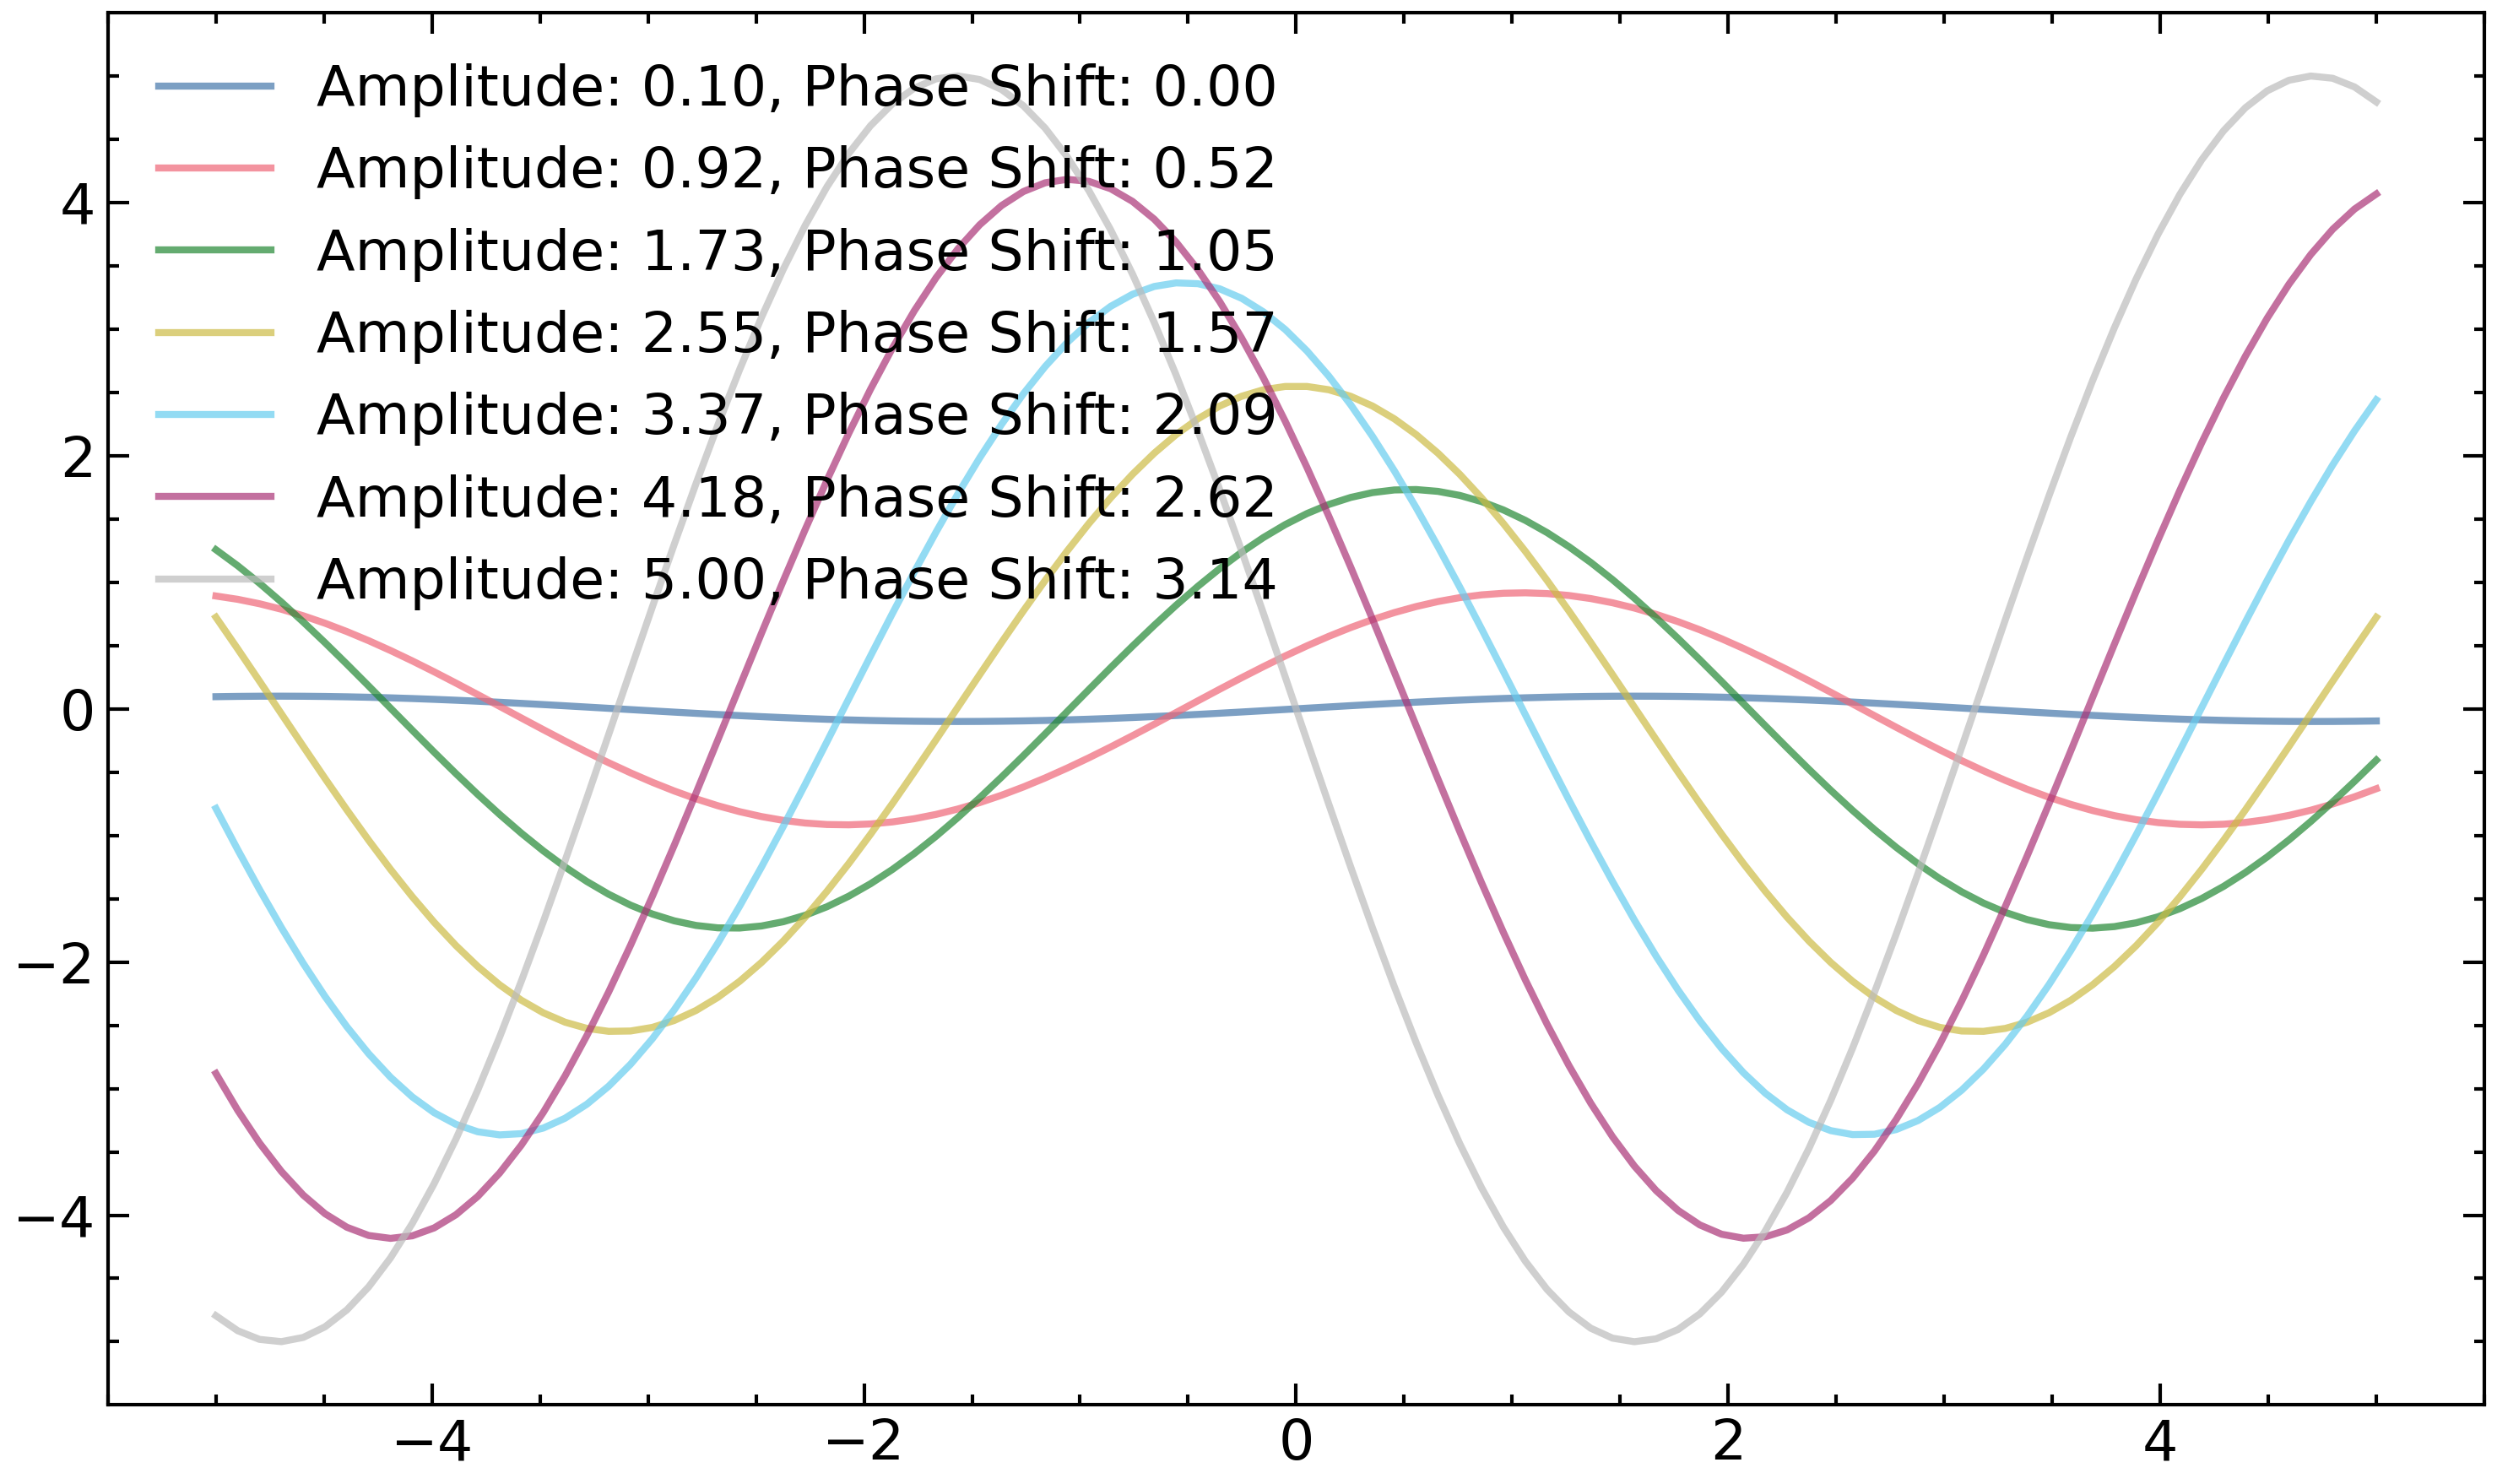

In [188]:
plt.figure(figsize=(10, 6))
for i, (task_data, task_target) in enumerate(zip(tasks_data, tasks_targets)):
    plt.plot(task_data, task_target, label=f"Amplitude: {amps[i]:.2f}, Phase Shift: {phases[i]:.2f}", alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(config['in_features'], config['n_nodes_per_layer']),  
            torch.nn.Linear(config['n_nodes_per_layer'], config['n_nodes_per_layer']), 
            torch.nn.Linear(config['n_nodes_per_layer'], config['out_features'])  
        ])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

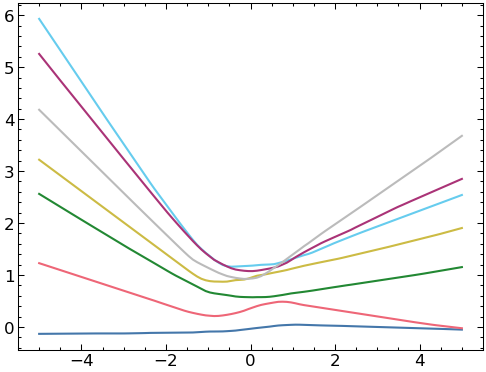

In [7]:
data = []
for x, y in zip(tasks_data, tasks_targets):
    data.append([x,y])
for i, (x, y) in enumerate(data):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    num_epochs = 10
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
    yhats = model(x.view(-1, 1))
    plt.plot(x, [yhat.detach().numpy() for yhat in yhats])

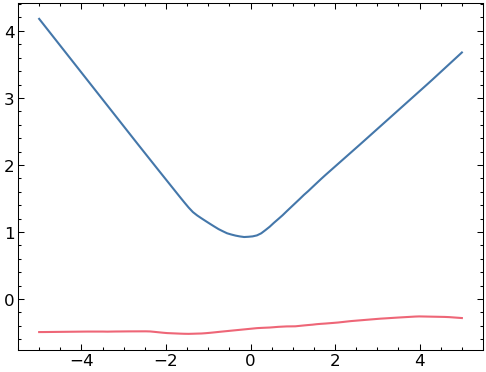

In [8]:
# experiment: replace initial and final layers with xavier initialized layers
new_initial = torch.nn.Linear(in_features=1, out_features=config['n_nodes_per_layer'])
new_final = torch.nn.Linear(in_features=config['n_nodes_per_layer'], out_features=1)
torch.nn.init.xavier_uniform_(new_initial.weight)
torch.nn.init.xavier_uniform_(new_final.weight)

yhats = model(x.view(-1, 1))
plt.plot(x, [yhat.detach().numpy() for yhat in yhats])

model_copy = copy.deepcopy(model)
model_copy.layers[0] = new_initial
model_copy.layers.pop(-1)
model_copy.layers.append(new_final)

yhats = model_copy(x.view(-1, 1))
plt.plot(x, [yhat.detach().numpy() for yhat in yhats]);

In [9]:
class LayerPool:
    def __init__(self, 
                layer_constructor: Type[torch.nn.Linear]=config['pool_layer_type'],
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                num_nodes_per_layer: int=config['n_nodes_per_layer'],
                layers: List[torch.nn.Linear]=None):
        self.layer_constructor = layer_constructor
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer

        if layers is None:
            self.layers = [self.layer_constructor(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)for _ in range(config['n_pool_hidden_layers'])]
            for _ in range(config['n_tasks']):
                self.layers.append(self.layer_constructor(in_features=in_features, out_features=num_nodes_per_layer))
                self.layers.append(self.layer_constructor(in_features=num_nodes_per_layer, out_features=out_features))
            [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]
        else:
            self.layers = layers
            config['n_pool_hidden_layers'] = len(self.layers)

        self.initial_input_layer = copy.deepcopy(random.choice([layer for layer in self.layers if layer.in_features==1]))
        self.initial_output_layer = copy.deepcopy(random.choice([layer for layer in self.layers if layer.out_features==1]))
        
    def __str__(self) -> str:
        return f"LayerPool(size={self.size}, layer_type={config['pool_layer_type']}, num_nodes_per_layer={config['n_nodes_per_layer']}"


In [10]:
class InnerNetworkAction(Enum):
    ADD = 1
    ERROR = 2

In [11]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as n_x.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data}, targets={self.targets}, info={self.info})'

In [137]:
class InnerNetwork(gymnasium.Env, torch.nn.Module):
    def __init__(self, 
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                calibration: bool=False,
                epoch: int=0,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.task = task
        self.layer_pool = layer_pool
        self.calibration = calibration
        self.in_features = in_features
        self.out_features = out_features
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.task_max_loss = config['task_max_loss'][self.task.info['i']]
        self.task_min_loss = config['task_min_loss'][self.task.info['i']]
        self.local_max_loss = -float('inf')
        self.local_min_loss = float('inf')

        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle)
        self.data_iter = iter(self.data_loader)
       
        # initial input and output layers to allow state calculation to get actions. these layers
        # are then replaced by the outer network. the objective of the outer network is to find
        # the best layers for a neural network (that means not just selecting the hidden layers).
        # the same hidden layers produce drastically different results with different input and output
        # layers 
        self.initial_input_layer = layer_pool.initial_input_layer
        self.initial_output_layer = layer_pool.initial_output_layer
        self.layers = torch.nn.ModuleList([self.initial_input_layer, self.initial_output_layer]) 
        self.layers_pool_indices = [] 
        self.actions_taken = []
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)

        self.timestep = 0
        self.loss_vals = []
        self.reward_vals = []
        self.errors = 0

        self.train()
        self.next_batch()
        self.train_inner_network()
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = gymnasium.spaces.discrete.Discrete(len(self.layer_pool.layers))

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'

        self.timestep += 1
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)
        self.next_batch()
        self.update(action)
        termination = False if len(self.layers)<config['n_layers_per_network'] else True
        if termination:
            self.train_inner_network()
        else:
            self.forward()

        # calibration is finding the min and max loss values for the task to
        # scale the loss (and the reward) between 0 and 1 across tasks
        if self.calibration==True:
            self.task_max_loss = max(self.curr['loss'], self.task_max_loss)
            self.task_min_loss = min(self.curr['loss'], self.task_min_loss) 
        self.local_max_loss = max(self.curr['loss'], self.local_max_loss)
        self.local_min_loss = min(self.curr['loss'], self.local_min_loss) 
        
        s_prime = self.build_state()
        reward = self.reward()
        self.log()

        # update pool
        for index, layer in zip(self.layers_pool_indices, self.layers[1:-1]):
            self.layer_pool.layers[index] = layer

        return (
            s_prime,
            reward, 
            termination,
            False,
            {}
        )

    def next_batch(self, throw_exception=False) -> None:
        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x'].view(-1, 1)
            self.curr['y'] = batch['y'].view(-1, 1)
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x'].view(-1, 1)
                self.curr['y'] = batch['y'].view(-1, 1)
                self.curr['info'] = batch['info']
    
    def update(self, action: np.int64) -> None:
        new_layer = self.layer_pool.layers[action]
        
        # first step and input layer and not already in network
        if self.timestep==1 \
            and new_layer.in_features==1 \
            and new_layer not in self.layers:
            
            self.layers[0] = new_layer
            self.curr['action_type'] = InnerNetworkAction.ADD
        # last step and output layer and not already in network
        elif self.timestep==2 \
            and new_layer.out_features==1 \
            and new_layer not in self.layers:

            self.layers[-1] = new_layer
            self.curr['action_type'] = InnerNetworkAction.ADD
        # not first or last step and hidden layer and not already in network
        elif self.timestep!=1 \
            and self.timestep!=2 \
            and new_layer not in self.layers \
            and new_layer.in_features!=1 \
            and new_layer.out_features!=1 \
            and len(self.layers) < config['n_layers_per_network']: 

            final_layer = self.layers.pop(-1) 
            self.layers.append(new_layer)
            self.layers.append(final_layer) 
            self.layers_pool_indices.append(torch.tensor(action))
            self.curr['action_type'] = InnerNetworkAction.ADD
        else: 
            self.curr['action_type'] = InnerNetworkAction.ERROR
            
    def forward(self) -> None:
        x = copy.deepcopy(self.curr['x'])
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
        self.curr['loss'].backward()
    
    def train_inner_network(self) -> None: 
        for _ in range(10):
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward()
            self.opt.step()
            self.next_batch()
    
    def build_state(self) -> np.ndarray:
        task_info = torch.tensor([self.task.info['amp'], self.task.info['phase_shift']]).squeeze()
        loss = torch.Tensor([self.curr['loss']])
        yhat_scale = torch.Tensor([torch.Tensor(torch.max(torch.abs(self.curr['y_hat']))).detach().item()])
        one_hot_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i] in self.layers else 0 for i in range(len(self.layer_pool.layers))]))
        layer_indices = [index + 1 for index in self.layers_pool_indices.copy()] # 0 bump by 1 to avoid 0th index layer being 0 since padding 0s too
        while len(layer_indices) < config['n_layers_per_network']:
            layer_indices.insert(0, 0)
        layer_indices = torch.tensor(layer_indices)
        return torch.concat((
            task_info,
            yhat_scale,
            layer_indices,
            one_hot_layers,
            loss,
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        # min-max scaled reward is negative loss of inner network multiplied 
        # by a scale factor that is "how bad" initial layers chosen are to 
        # credit those early actions more in the return

        if self.calibration:
            scale_factor = 1
        else:
            # "how bad" the initial layers are is a function of their loss 
            # versus the min and max loss seen for task to ensure that credit 
            # assignment skews towards ADD rather than TRAIN actions (because 
            # Adam optimizer can train any set of layers to good performance 
            # in few steps, but that's not the learning objective) 
            # e.g., with max loss for task=14, 
            # max loss for task=12, reduce each reward with a factor of 
            # 0.14 <- 14-12/14 = 2/14 = 0.14
            scale_factor = ((self.task_max_loss - self.local_max_loss) / self.task_max_loss) 

        if (self.curr['action_type'] == InnerNetworkAction.ERROR):
            reward = torch.tensor(-1)
        else:
            epsilon = 1e-8 # prevent division by zero
            reward = - (((self.curr['loss'] - self.task_min_loss + epsilon) / (self.task_max_loss - self.task_min_loss + epsilon)))
            reward = scale_factor * reward
        
        self.curr['reward'] = reward
        return reward

    def log(self):
        task_num = str(self.task.info['i'])
        self.loss_vals.append(copy.copy(self.curr['loss'].item()))
        self.reward_vals.append(copy.copy(self.curr['reward'].item()))
        self.errors = self.errors + 1 if self.curr['action_type']==InnerNetworkAction.ERROR else self.errors
        # wandb.log({ f'loss_task{task_num}_per_step' : self.curr['loss']})
        # wandb.log({ f'reward_task{task_num}_per_step' : self.curr['reward']})
        # wandb.log({ f'action_types_task{task_num}_per_step' : wandb.Histogram(torch.tensor([self.actions_taken]))})
        # wandb.log({ f'pool_indices_task{task_num}_per_step' : wandb.Histogram(torch.tensor(self.layers_pool_indices))})

    def reset(self, seed=None) -> np.ndarray:
        # print(f"[INFO] Reset at timestep={self.timestep}, layers={self.layers_pool_indices}")
        self.timestep = 0
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.initial_input_layer = copy.deepcopy(random.choice([layer for layer in self.layer_pool.layers if layer.in_features==1]))
        self.initial_output_layer = copy.deepcopy(random.choice([layer for layer in self.layer_pool.layers if layer.out_features==1]))
        self.layers = torch.nn.ModuleList([self.initial_input_layer, self.initial_output_layer]) 
        self.layers_pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.actions_taken = []
        self.loss_vals = []
        self.reward_vals = []
        # TODO is to try reseting local max and min losees at the episode level and not
        # just at the epoch level as is now
        # self.local_max_loss = None
        # self.local_min_loss = None

        self.train()
        self.next_batch()
        self.train_inner_network()
        return self.build_state(), None

In [139]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        path: str,
        run: int=1,
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.path=path
        if config['sb3_model']=='PPO':
            model = PPO
        elif config['sb3_model']=='RecurrentPPO':
            model = RecurrentPPO
        dummy_env = self.make_env(tasks[0], layer_pool) 
        self.run = run
        self.model = model(policy, dummy_env, seed=config['seed'])
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.cumureward_epochs = defaultdict(lambda: [])
        self.cumuloss_epochs = defaultdict(lambda: [])
        self.errors_epochs = defaultdict(lambda: [])

    def __str__(self) -> str:
        return f'REML(model={self.model}, policy={self.policy})'
    
    def make_env(self, task, epoch=None, calibration=False) -> gymnasium.Env:
        return gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, self.layer_pool, epoch=epoch, calibration=calibration))
    
    def calibrate(self):
        # get the min and max loss per task to min-max
        # scale across tasks so no one task dominates learning
        # based on the magnitude of the loss (and reward) signal
        for i, task in enumerate(self.tasks): 
            print(f'[INFO] Calculating min and max loss for task {i+1}.')
            self.env = self.make_env(task, calibration=True)
            self.model.set_env(self.env)
            self.model.learn(total_timesteps=self.timesteps)
            config['task_min_loss'][task.info['i']] = min(self.env.task_min_loss, config['task_min_loss'][task.info['i']])
            config['task_max_loss'][task.info['i']] = max(self.env.task_max_loss, config['task_max_loss'][task.info['i']])
    
    def train(self):
        # wraps stablebaselines3 learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 

        # get min and max loss for task to calculate learning signals
        self.calibrate()

        # to calculate variance
        # e.g., task: [ n: [epoch: [100 values]] ] / array with n rows, epoch columns 
        # where cell @ [nth run][mth epoch] is cumulative loss/reward
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch={epoch+1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.task = task 
                self.env = self.make_env(task, epoch=epoch)
                self.model.set_env(self.env)
                self.model.learn(total_timesteps=self.timesteps)
                
                # update min and max loss for task
                local_min_loss = self.env.local_min_loss
                local_max_loss = self.env.local_max_loss
                config['task_min_loss'][self.task.info['i']] = min(local_min_loss, config['task_min_loss'][self.task.info['i']])
                config['task_max_loss'][self.task.info['i']] = max(local_max_loss, config['task_max_loss'][self.task.info['i']])

                # track reward and loss for plots
                self.cumureward_epochs[str(self.task.info['i'])].append(sum(self.env.reward_vals))
                self.cumuloss_epochs[str(self.task.info['i'])].append(sum(self.env.loss_vals))
                self.errors_epochs[str(self.task.info['i'])].append(self.env.errors)

                # log to wandb
                # wandb.log({ f'errors_run{self.run}_task{i}_per_epoch' : self.env.errors })
                # wandb.log({ f'cumulative_reward_run{self.run}_task{i}_per_epoch' : sum(self.env.reward_vals) })
                # wandb.log({ f'cumulative_loss_run{self.run}_task{i}_per_epoch' : sum(self.env.loss_vals) })
                # wandb.log({ f'pool_indices_run{self.run}_task{i}_per_epoch' : wandb.Histogram(torch.tensor(self.env.layers_pool_indices))})

                # NOTE running this during training consumes a lot of memory
                # plot_sine_curves(self, tasks=[self.task], path=self.path, run=self.run, epoch=epoch, image=True)

In [206]:
def plot_loss_vs_step_curves(remls,
                             tasks,
                             path,
                             grid=True,
                             steps=100,
                             image=False,) -> Tuple[dict]:
                             
    meta_task_mean = defaultdict(lambda: [])
    meta_task_std = defaultdict(lambda: [])
    scratch_task_mean = defaultdict(lambda: [])
    scratch_task_std = defaultdict(lambda: [])
    meta_task_lossbystep = defaultdict(lambda: [])
    scratch_task_lossbystep = defaultdict(lambda: [])

    for i, task in enumerate(tasks): 
        for reml in remls:
            env = reml.make_env(task)
            reml.model.set_env(env, force_reset=False)
            obs, _ = env.reset()
            loss_for_this_reml = []

            # meta trained network loss
            while len(env.layers) < config['n_layers_per_network']:
                action, _ = reml.model.predict(obs)
                obs, _, done, _, _ = env.step(action)
                if done: # network built
                    layers = copy.deepcopy(env.layers)
                    network = RegressionModel()
                    network.layers = layers
                    optimizer = torch.optim.Adam(network.parameters(), lr=config['learning_rate'])
                    criterion = torch.nn.MSELoss()
                    for _ in range(steps):
                        optimizer.zero_grad() 
                        outputs = network(task.data.view(-1, 1))
                        loss = criterion(outputs, task.targets.view(-1,1))
                        loss.backward()
                        optimizer.step()
                        loss_for_this_reml.append(loss.detach().numpy())
            meta_task_lossbystep[task].append(loss_for_this_reml)

            # scratch trained network loss
            network = RegressionModel()
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(network.parameters(), lr=config['learning_rate'])
            network.train()
            loss_for_this_scratch = []
            for _ in range(steps):
                optimizer.zero_grad() 
                outputs = network(task.data.view(-1, 1))
                loss = criterion(outputs, task.targets.view(-1,1))
                loss.backward()
                optimizer.step()
                loss_for_this_scratch.append(loss.detach().numpy())
            scratch_task_lossbystep[task].append(loss_for_this_scratch)

        # meta trained network mean, std
        array = np.array(meta_task_lossbystep[task])
        meta_task_mean[task] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
        meta_task_std[task] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 

        # scratch trained network mean, std
        array = np.array(scratch_task_lossbystep[task])
        scratch_task_mean[task] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
        scratch_task_std[task] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 

    if grid:
        all_handles, all_labels = [], []
        figures = {0 : 'a', 1 : 'b', 2: 'c', 3 : 'd', 4 : 'e', 5 : 'f'}
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
        axs = axs.flatten()
        for i, (ax, task) in enumerate(zip(axs, tasks)):
            meta_mean, = ax.plot(range(len(meta_task_mean[task])), meta_task_mean[task], label=f'Meta-trained mean')
            meta_std = ax.fill_between(
                range(len(meta_task_mean[task])), 
                [mean - std for mean, std in zip(meta_task_mean[task], meta_task_std[task])], 
                [mean + std for mean, std in zip(meta_task_mean[task], meta_task_std[task])],
                alpha=0.2, 
                label='Meta-trained network std')
            scratch_mean, = ax.plot(range(len(scratch_task_mean[task])), scratch_task_mean[task], label=f'Baseline mean')
            scratch_std = ax.fill_between(
                range(len(scratch_task_mean[task])), 
                [mean - std for mean, std in zip(scratch_task_mean[task], scratch_task_std[task])], 
                [mean + std for mean, std in zip(scratch_task_mean[task], scratch_task_std[task])],
                alpha=0.2, 
                label='Baseline std')
            ax.set_xlabel('Steps', fontsize=14)
            ax.set_ylabel('MSE loss', fontsize=14)
            ax.set_title(f"({figures[i]}) amplitude={round(task.info['amp'].item(), 1)}, phase shift={round(task.info['phase_shift'].item(), 1)}", pad=12, fontproperties='Times New Roman', fontsize=16)
        all_handles.extend([meta_mean, meta_std, scratch_mean, scratch_std])
        all_labels.extend([meta_mean.get_label(), meta_std.get_label(), scratch_mean.get_label(), scratch_std.get_label()])
        fig.subplots_adjust(hspace=0.4, wspace=0.35)
        fig.legend(all_handles, all_labels, loc='lower center', ncol=6, fontsize=12)
        plot_title = f'loss_versus_step_training'
        plot_path = f'{path}/{plot_title}.png'  
        if image:
            print(f"[INFO] Image saved to {plot_path}")
            fig.savefig(plot_path, bbox_inches='tight')
    else:
        fig = plt.figure()
        plt.plot(range(len(meta_task_mean[task])), meta_task_mean[task], label='Meta-trained network mean')
        plt.plot(range(len(scratch_task_mean[task])), scratch_task_mean[task], label='Baseline mean')
        plt.fill_between(
            range(len(meta_task_mean[task])), 
            [mean - std for mean, std in zip(meta_task_mean[task], meta_task_std[task])], 
            [mean + std for mean, std in zip(meta_task_mean[task], meta_task_std[task])],
            alpha=0.2, 
            label='Meta-trained network std')
        plt.fill_between(
            range(len(scratch_task_mean[task])), 
            [mean - std for mean, std in zip(scratch_task_mean[task], scratch_task_std[task])], 
            [mean + std for mean, std in zip(scratch_task_mean[task], scratch_task_std[task])],
            alpha=0.2, 
            label='Baseline std')
        plt.xlabel('Steps')
        plt.ylabel('MSE loss')
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(loc='upper right')
        plt.show()
        plot_title = f'loss_versus_step_eval'
        plot_path = f'{path}/{plot_title}.png'  
        if image:
            print(f"[INFO] Image saved to {plot_path}")
            fig.savefig(plot_path, bbox_inches='tight')

def plot_sine_curves(remls, 
                     tasks, 
                     path,
                     grid=True,
                     image=False, 
                     args=defaultdict()) -> dict:

    task_mean = defaultdict(lambda: [])
    task_std = defaultdict(lambda: [])
    task_yhatsbyrun = defaultdict(lambda: [])

    for i, task in enumerate(tasks): 
        for reml in remls:
            env = reml.make_env(task)
            reml.model.set_env(env, force_reset=False)
            obs, _ = env.reset()

            # build network 
            while len(env.layers)!=config['n_layers_per_network']:
                action, _ = reml.model.predict(obs)
                obs, _, _, _, _ = env.step(action)

            # run network to get yhats
            xs, ys = task.data.clone(), task.targets.clone()
            xs, ys = xs.view(len(xs), 1), ys.view(len(ys), 1)
            env.curr['x'] = xs
            env.curr['y'] = ys
            env.forward()
            yhats = env.curr['y_hat']
            yhats = [yhat.detach().numpy() for yhat in yhats]
            task_yhatsbyrun[task].append(yhats)
    
        array = np.array(task_yhatsbyrun[task])
        task_mean[task] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
        task_std[task] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 

            # # plot sine curve
            # plt.figure()
            # if epoch!=None and run!=None:
            #     plot_title = f"Sine curve (run={run}, epoch={epoch}, task={task.info['i']+1})" 
            # elif epoch!=None:
            #     plot_title = f"Sine curve (epoch={epoch}, task={task.info['i']+1})" 
            # else:
            #     plot_title= f"Sine curve (task={task.info['i']+1})"
            # plot_path = f'{path}/{plot_title}.png'  
            # plt.xticks(fontsize=18)
            # plt.yticks(fontsize=18)

            # plt.plot(task.data, [yhat.detach().numpy() for yhat in yhats], **args)
            # plt.plot(task.data, task.targets, label='ground truth', linestyle='--')
            # plt.legend(loc='upper right')

            # # save png / wandb
            # if image:
            #     plt.savefig(plot_path, bbox_inches='tight')
            #     wandb.log({plot_title: wandb.Image(plot_path)})

            # # return if needed 
            # xs, yhats = task.data, [yhat.detach().numpy() for yhat in yhats]
            # task_yhats[task] = yhats

        # return task_yhats

    if grid:
        all_handles, all_labels = [], []
        figures = {0 : 'a', 1 : 'b', 2: 'c', 3 : 'd', 4 : 'e', 5 : 'f'}
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
        axs = axs.flatten()
        for i, (ax, task) in enumerate(zip(axs, tasks)):
            mean, = ax.plot(task.data, task_mean[task], label='Mean')
            groundtruth, = ax.plot(task.data, task.targets, label='Ground truth', linestyle='--')
            std = ax.fill_between(
                task.data, 
                [mean - std for mean, std in zip(task_mean[task], task_std[task])], 
                [mean + std for mean, std in zip(task_mean[task], task_std[task])],
                alpha=0.2, 
                label='Std')
            ax.set_title(f"({figures[i]}) amplitude={round(task.info['amp'].item(), 1)}, phase shift={round(task.info['phase_shift'].item(), 1)}", pad=12, fontproperties='Times New Roman', fontsize=16)
        all_handles.extend([mean, std, groundtruth])
        all_labels.extend([mean.get_label(), std.get_label(), groundtruth.get_label()])
        fig.subplots_adjust(hspace=0.4, wspace=0.35)
        fig.legend(all_handles, all_labels, loc='lower center', ncol=6, fontsize=12)
        plot_title = f'sine_curves_training'
        plot_path = f'{path}/{plot_title}.png'  
        if image:
            print(f"[INFO] Image saved to {plot_path}")
            fig.savefig(plot_path, bbox_inches='tight')
    else:
        fig = plt.figure()
        plt.plot(task.data, task_mean[task], label='Mean')
        plt.plot(task.data, task.targets, label='Ground truth', linestyle='--')
        plt.fill_between(
            task.data, 
            [mean - std for mean, std in zip(task_mean[task], task_std[task])], 
            [mean + std for mean, std in zip(task_mean[task], task_std[task])],
            alpha=0.2, 
            label='Std')
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        # plt.legend(loc='lower center')
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncols=3)
        plt.show()
        plot_title = f'sine_curves_eval'
        plot_path = f'{path}/{plot_title}.png'  
        if image:
            print(f"[INFO] Image saved to {plot_path}")
            fig.savefig(plot_path, bbox_inches='tight')

def plot_data_with_variance(data, 
                            eval_task_num, 
                            title, 
                            path,
                            xlabel,
                            image=False):
    task_mean = {}
    task_std = {}
    for i, task_values in enumerate(data.values()):
        if i==eval_task_num: continue
        array = np.array(task_values)
        assert np.ndim(array)==2, f"[ERROR] Expected ndim=2, got {np.ndim(array)}"

        # rows are over n_runs, cols are epochs
        task_mean[i] = [np.mean(array[:, epoch]) for epoch in range(array.shape[1])]
        task_std[i] = [np.std(array[:, epoch]) for epoch in range(array.shape[1])] 

        plt.figure()
        plt.plot(range(len(task_mean[i])), task_mean[i], label='mean')
        plt.fill_between(
            range(len(task_mean[i])), 
            [mean - std for mean, std in zip(task_mean[i], task_std[i])], 
            [mean + std for mean, std in zip(task_mean[i], task_std[i])],
            alpha=0.2, 
            label='std')
        plot_title = f"{title} (task={i+1})"
        plt.title(plot_title)
        plt.xticks(range(1, config['epochs']+1, 10))
        plt.ylabel(xlabel)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel("Epochs")
        plt.legend(loc='upper right')

        # save png / wandb
        plot_path = f'{path}/{plot_title}.png'  
        if image:
            print(f"[INFO] Image saved to {plot_path}")
            plt.savefig(plot_path, bbox_inches='tight')
            wandb.log({plot_title: wandb.Image(plot_path)})

def plot_few_shot_learning(reml,
                           eval_task,
                           path,
                           k=5,
                           image=False):

    # network still recieves the same 100 x values {-5, ..., 5}
    # the difference is that a target value is only provided for 5 or 10 of these 100 values

    k_data_points = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
    env = reml.make_env(eval_task)
    reml.model.set_env(env, force_reset=False)
    reml.task = eval_task

    # build network in env, then generate plots
    obs, _ = env.reset()
    while len(env.layers)!=config['n_layers_per_network']:
        action, _ = reml.model.predict(obs)
        obs, _, done, _, _ = env.step(action)
        if done: # network built
            layers = copy.deepcopy(env.layers)
            network = RegressionModel()
            network.layers = layers
            optimizer = torch.optim.Adam(network.parameters(), lr=config['learning_rate'])
            criterion = torch.nn.MSELoss()

            k_x = k_data_points[:, 0].clone()
            k_x = k_x.view(len(k_x), 1) # reshape batch to k (k, 1)
            k_y = k_data_points[:, 1].clone()
            k_y = k_y.view(len(k_y), 1)

            # 0 grad steps / preupdate on all data
            xs = eval_task.data.clone()
            preupdate_outputs = network(xs.view(len(xs), 1)) # reshape to dataset size (100, 1)

            # 1 grad step on k 
            for _ in range(1):
                optimizer.zero_grad()
                outputs = network(k_x)
                loss = criterion(outputs, k_y)
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()
            outputs = network(xs.view(len(xs), 1)) # but then get curve for full dataset
            outputs_after_1_grad_step = [output.detach().numpy() for output in outputs]

            # 10 grad step
            for _ in range(10):
                optimizer.zero_grad() 
                outputs = network(k_x)
                loss = criterion(outputs, k_y)
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()
            outputs = network(xs.view(len(xs), 1))
            outputs_after_10_grad_step = [output.detach().numpy() for output in outputs]
        
            continue

    # pre-update plot
    plt.figure()
    plt.plot(eval_task.data, [yhat.detach().numpy() for yhat in preupdate_outputs], linestyle='--', label='pre-update')

    # ground truth plot
    plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

    # k points plot
    plt.scatter(k_data_points[:, 0], k_data_points[:, 1], marker='^', color='b', label='k points')

    # 1 grad step training plot
    plt.plot(eval_task.data, outputs_after_1_grad_step, label='1 grad step')
        
    # 10 grad steps training plot
    plt.plot(eval_task.data, outputs_after_10_grad_step, label='10 grad step')

    plot_title = f'Few shot learning (evaluation task, k={k})'
    plt.title(plot_title)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()

    # save png / wandb
    plot_path = f'{path}/{plot_title}.png'  
    if image:
        plt.savefig(plot_path, bbox_inches='tight')
        wandb.log({plot_title: wandb.Image(plot_path)})

## train

In [ ]:
config['wandb_run'] = ''
wandb.init(
    project='reinforcement-meta-learning',
    config=config,
    name=config['wandb_run']
)

In [192]:
# create tasks
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
eval_task = random.choice(list(tasks))
training_tasks = list(set(tasks) - {eval_task})

# n models saved, n pools saved, and 1 data dict saved
# e.g.,
# PPO_1218_10-02_model_n -> run n model
# PPO_1218_10-02_layers_n -> run n layers
# data/PPO_1218_10-02 -> all runs data
cumureward_task_runbyepoch = defaultdict(lambda: [])
cumuloss_task_runbyepoch = defaultdict(lambda: [])
errors_task_runbyepoch = defaultdict(lambda: [])
timestamp = datetime.datetime.now().strftime('%m%d_%H-%M')
name = f"{config['sb3_model']}_{timestamp}"
config['timestamp'] = timestamp
data_path = f"{config['data_dir']}/{name}"
os.makedirs(data_path, exist_ok=True)

# save tasks
torch.save(training_tasks, f'{name}_trainingtasks.pth')
torch.save(eval_task, f'{name}_evaltask.pth')

for run in range(1, config['n_runs']+1):     
    print(f"[INFO] n={run}")

    randomize_seed()

    # train
    pool = LayerPool()
    reml = REML(tasks=training_tasks, layer_pool=pool, run=run, path=data_path)
    reml.train()

    # save model
    model_path = f"{data_path.split('/', 1)[-1]}_model_{run}"
    reml.model.save(model_path)

    # save pool
    layers = copy.deepcopy(pool.layers)
    layers.insert(0, pool.initial_input_layer)
    layers.append(pool.initial_output_layer)
    torch.save(layers, f'{name}_layers_{run}.pth')

    # save return, loss, and error data
    for task in tasks:
        cumureward_task_runbyepoch[str(task.info['i'])].append(reml.cumureward_epochs[str(task.info['i'])])
        cumuloss_task_runbyepoch[str(task.info['i'])].append(reml.cumuloss_epochs[str(task.info['i'])])
        errors_task_runbyepoch[str(task.info['i'])].append(reml.errors_epochs[str(task.info['i'])])
    with open(f'{data_path}/{name}_cumureward', 'w') as json_file:
        json.dump(cumureward_task_runbyepoch, json_file, indent=4)
    with open(f'{data_path}/{name}_cumuloss', 'w') as json_file:
        json.dump(cumuloss_task_runbyepoch, json_file, indent=4)
    with open(f'{data_path}/{name}_errors', 'w') as json_file:
        json.dump(errors_task_runbyepoch, json_file, indent=4)


[INFO] n=1
[INFO] Calculating min and max loss for task 1.


KeyboardInterrupt: 

## load

In [17]:
print(name)
print(data_path) 

PPO_1221_08-14
data/PPO_1221_08-14


In [195]:
# override for past runs
config['n_runs'] = 10
name = 'RecurrentPPO_1220_16-59'
data_path = f'slurm/{name}'

In [196]:
# load tasks (once)
# load run data (once)
# for all runs
#   load pool
#   load model
training_tasks = torch.load(f'{name}_trainingtasks.pth')
eval_task = torch.load(f'{name}_evaltask.pth')
path = os.path.join(os.getcwd(), data_path, name)
cumureward = json.load(open(f"{path}_cumureward", 'r'))
cumuloss = json.load(open(f"{path}_cumuloss", 'r'))
errors = json.load(open(f"{path}_errors", 'r'))
remls = []
for i in range(1, config['n_runs']+1):
    layers = torch.load(f'{name}_layers_{i}.pth')
    pool = LayerPool()
    pool.initial_input_layer = layers[0]
    pool.initial_output_layer = layers.pop()
    pool.layers = layers
    reml = REML(layer_pool=pool, tasks=tasks, path=data_path)
    reml.model.load(f'{name}_model_{i}')
    remls.append(reml)


## plot

grid:task=5
grid:task=4
grid:task=3
grid:task=0
grid:task=1
grid:task=6
[INFO] Image saved to slurm/RecurrentPPO_1220_16-59/loss_versus_step_training.png
non-grid:task=2


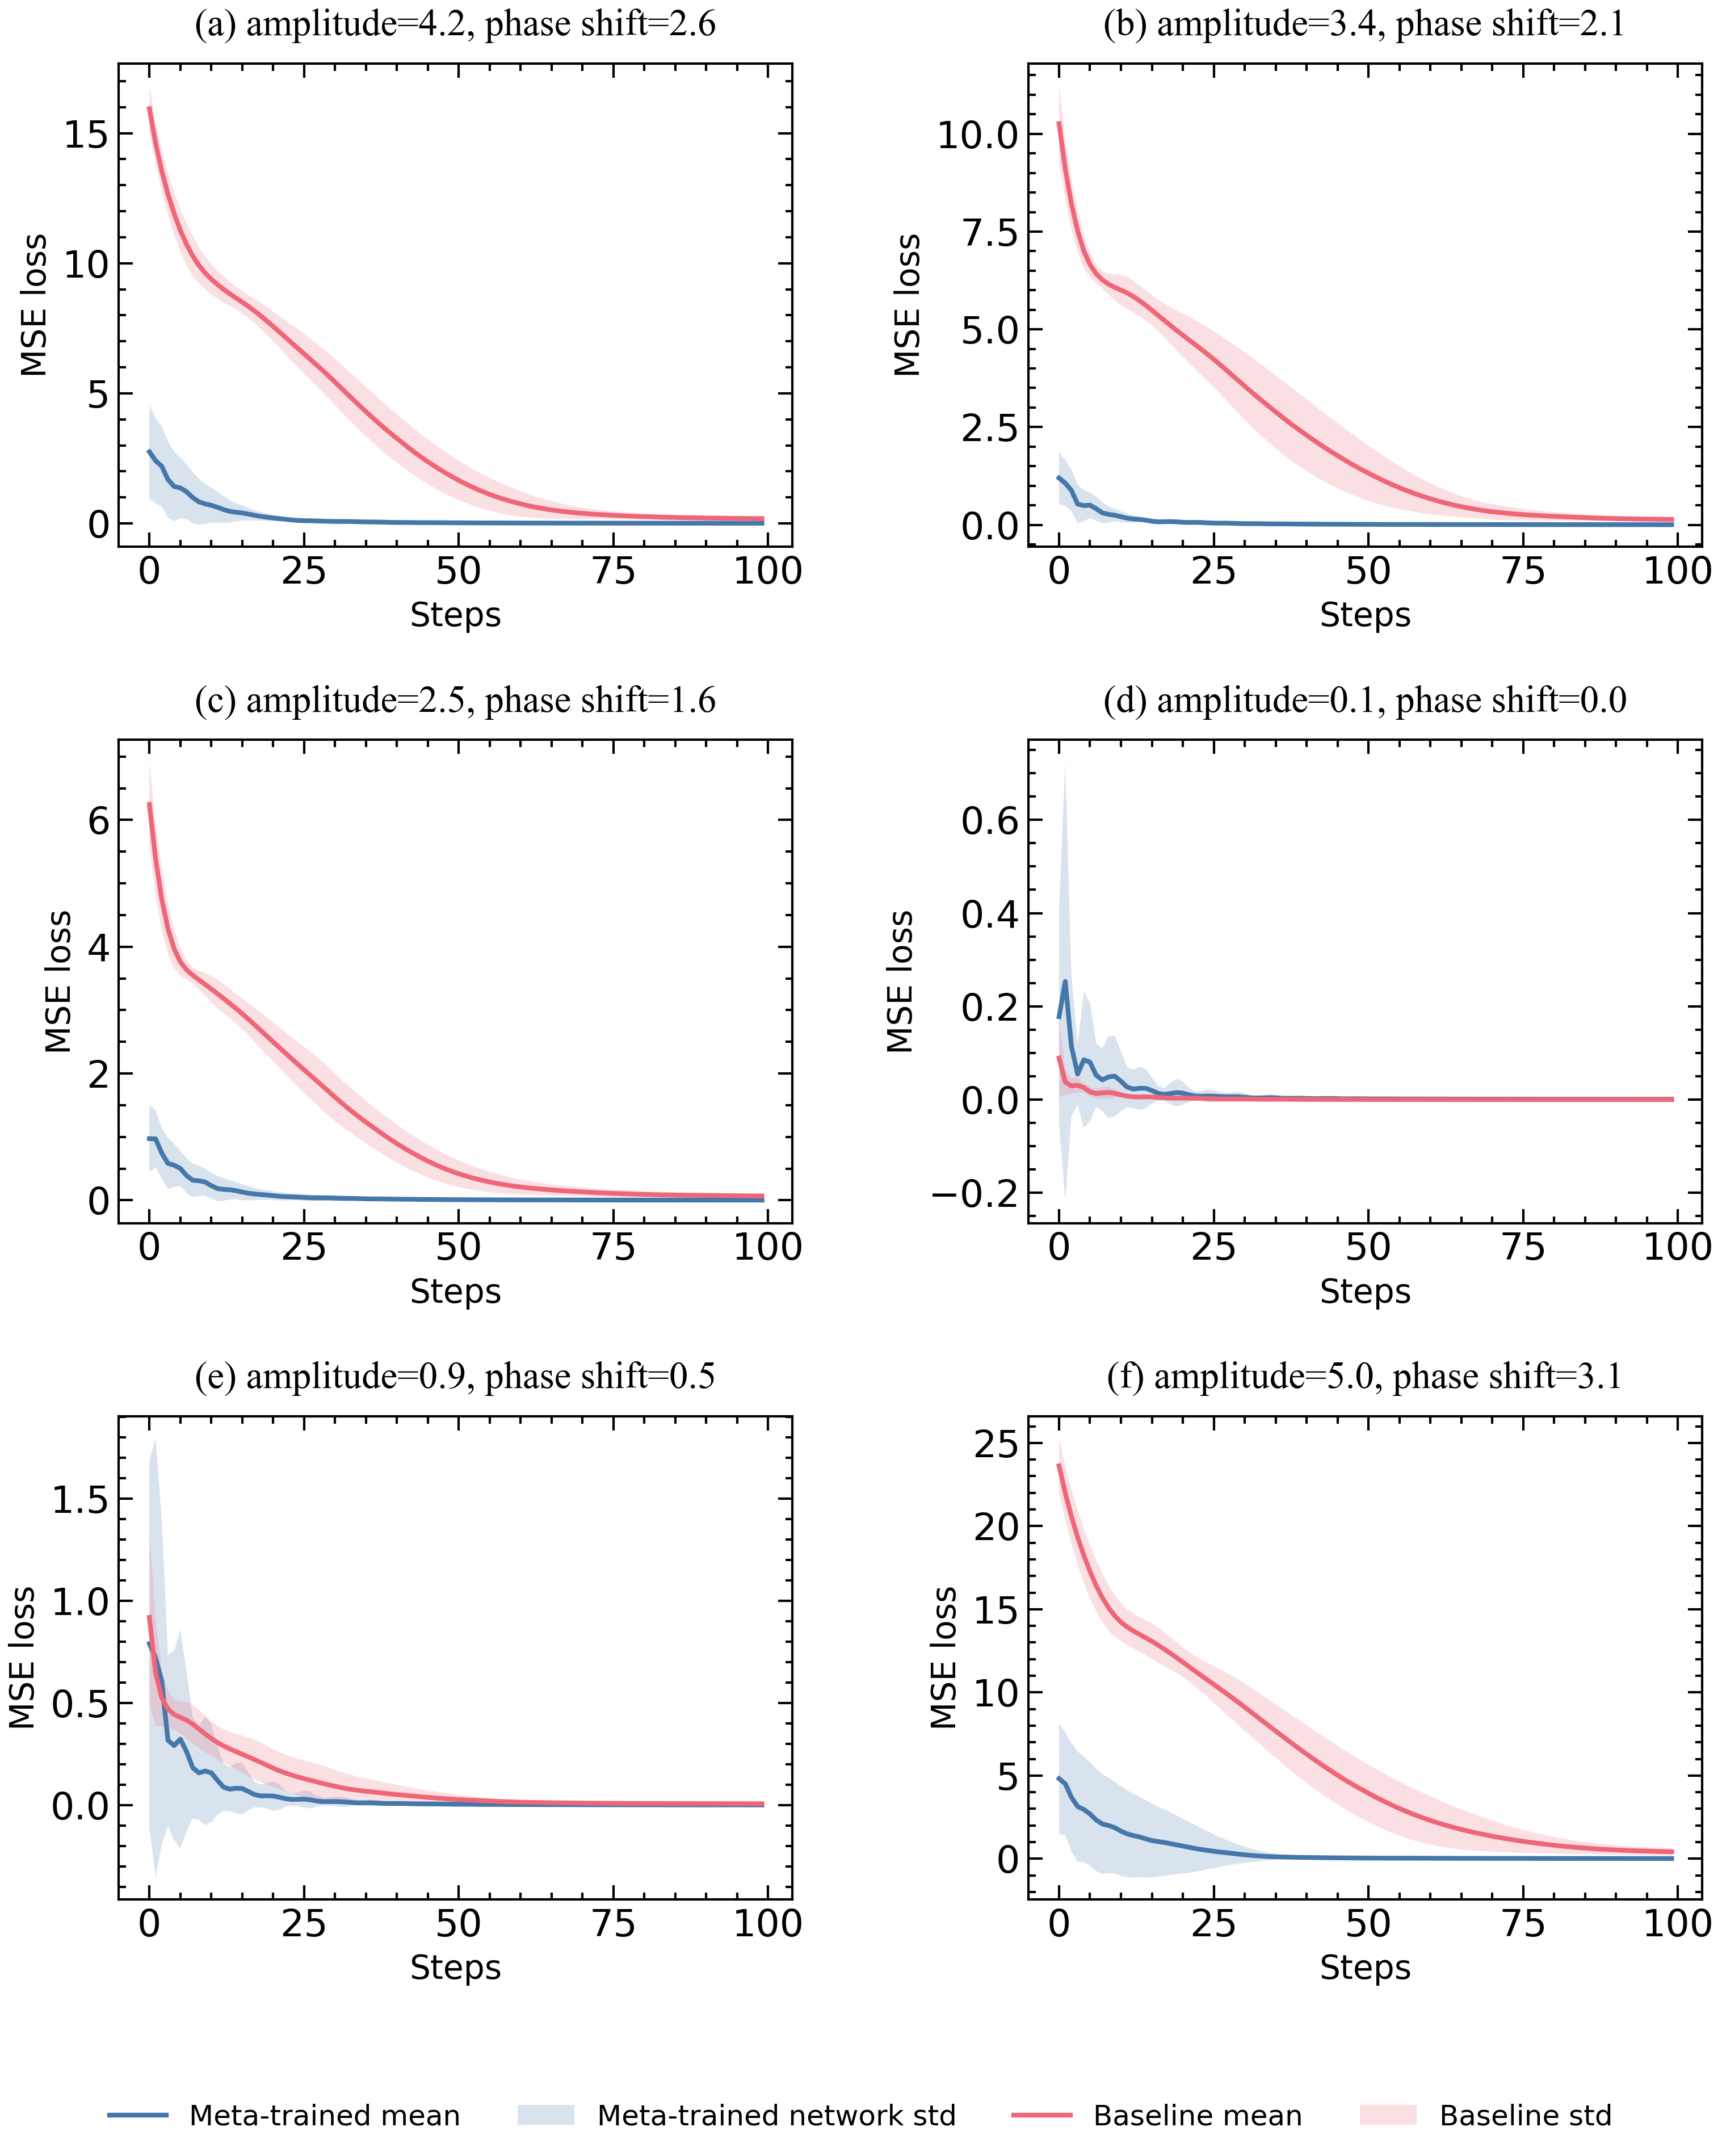

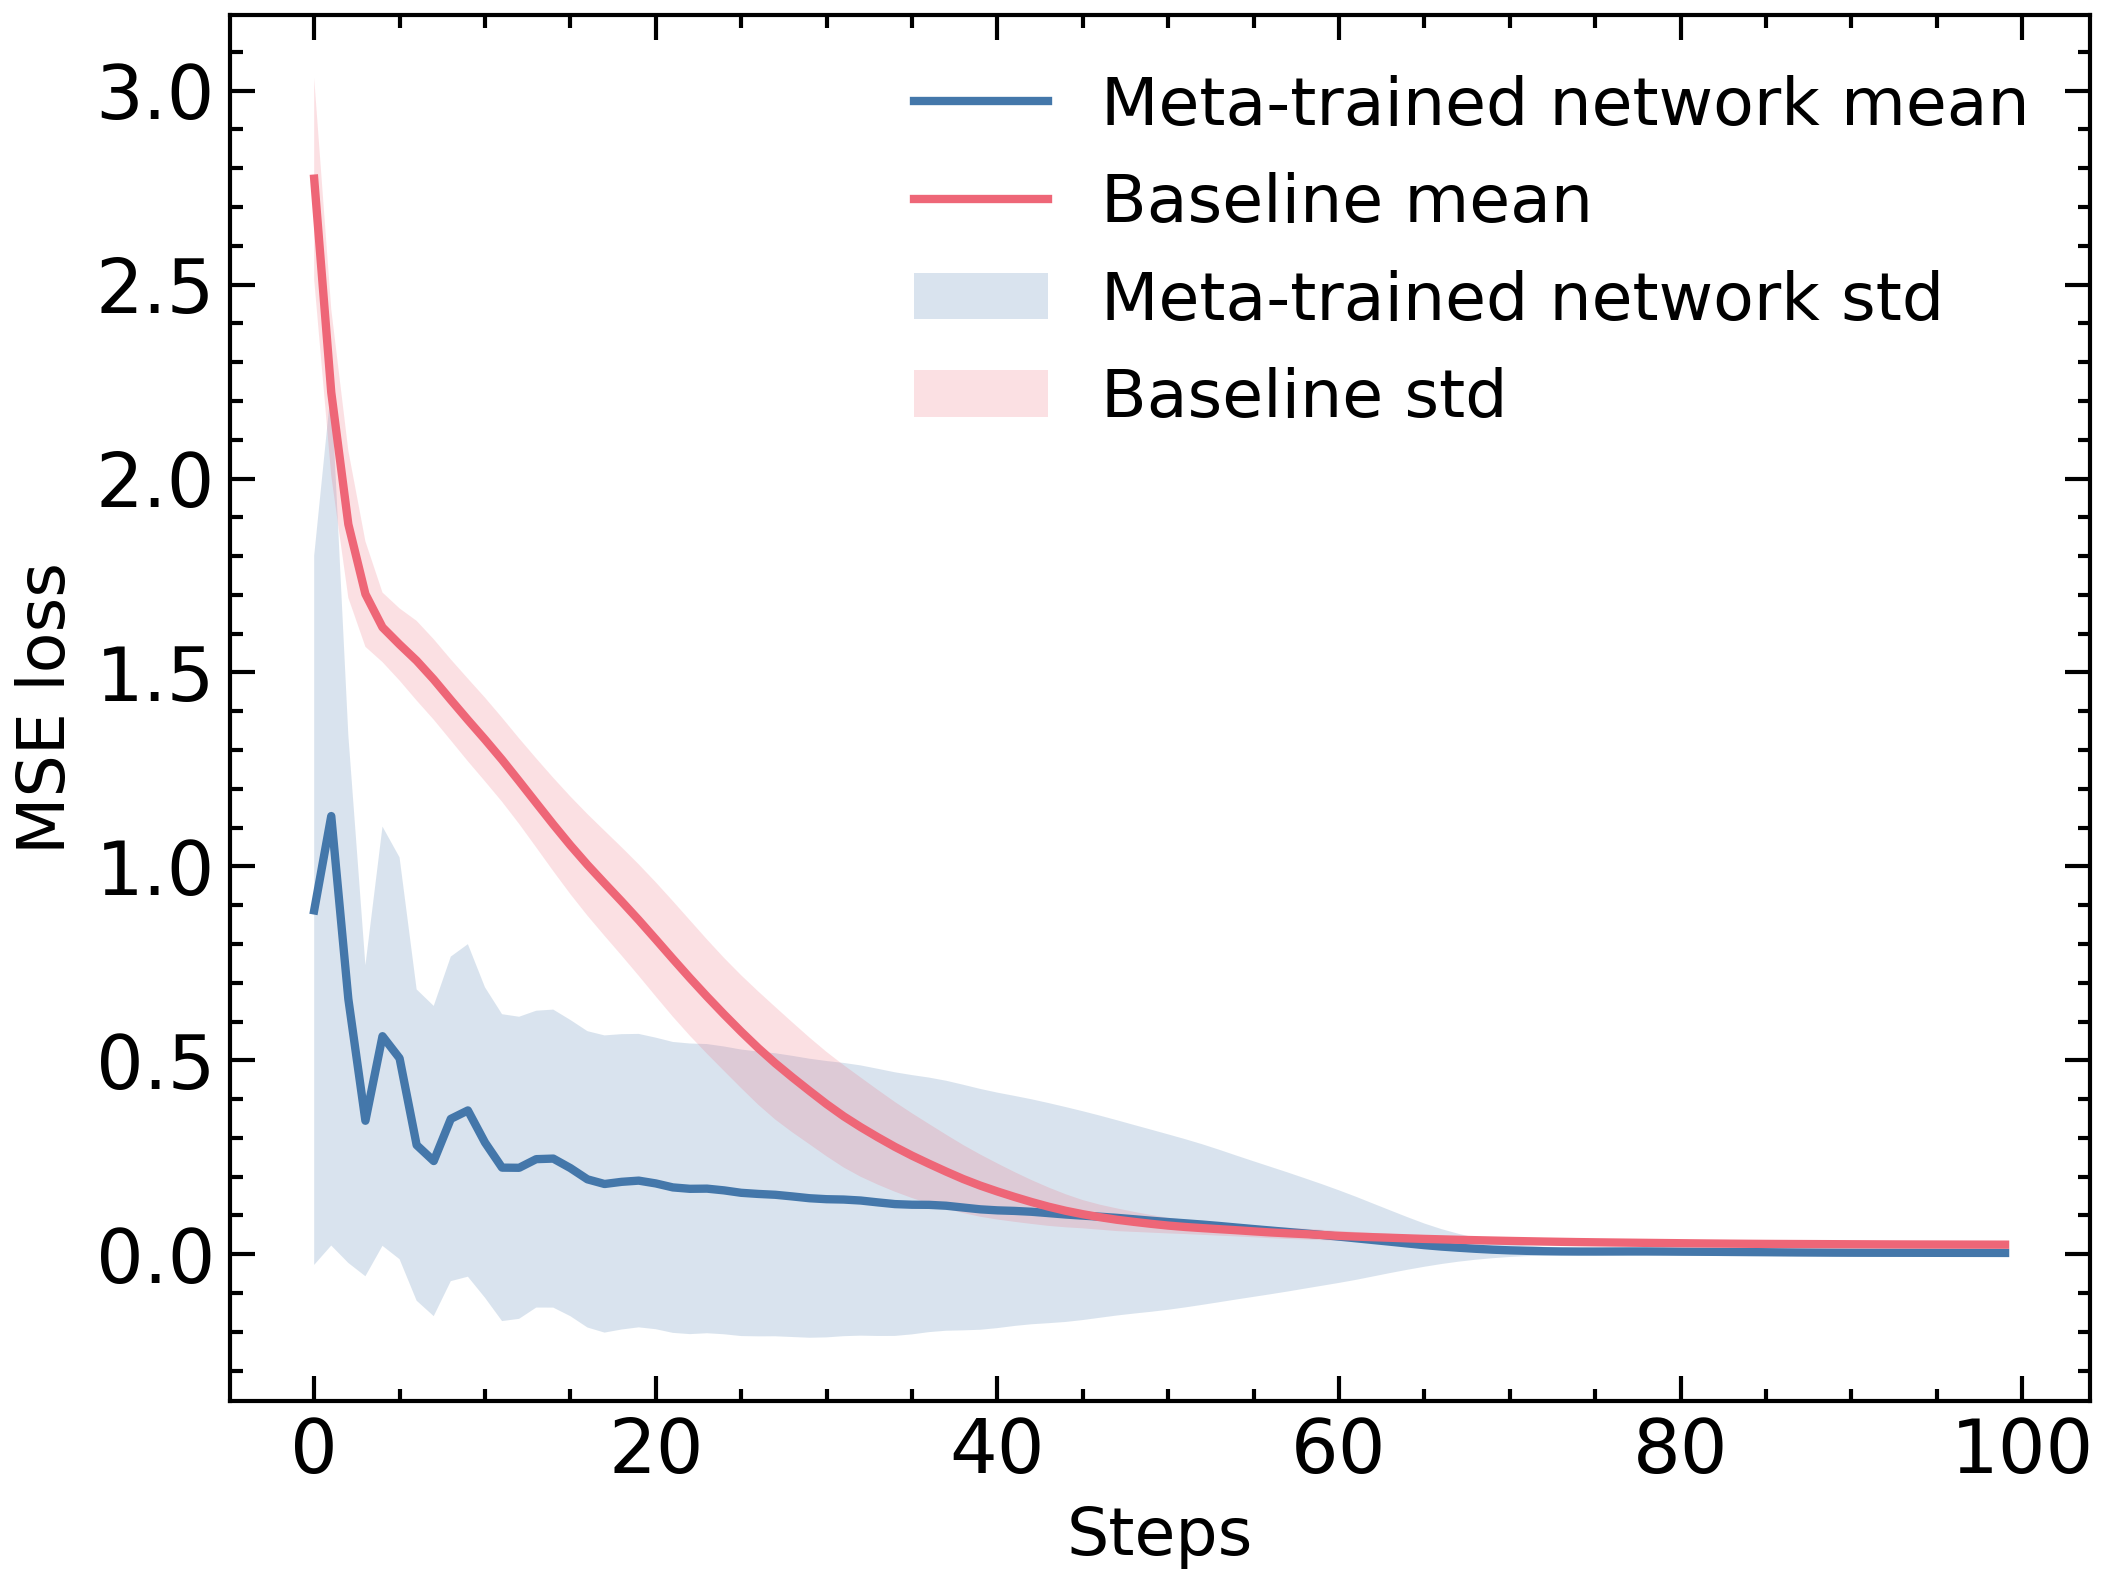

[INFO] Image saved to slurm/RecurrentPPO_1220_16-59/loss_versus_step_eval.png


In [159]:
plot_loss_vs_step_curves(remls, tasks=training_tasks, path=data_path, grid=True, image=True)
plot_loss_vs_step_curves(remls, tasks=[eval_task], path=data_path, grid=False, image=True)

[INFO] Image saved to slurm/RecurrentPPO_1220_16-59/sine_curves_training.png


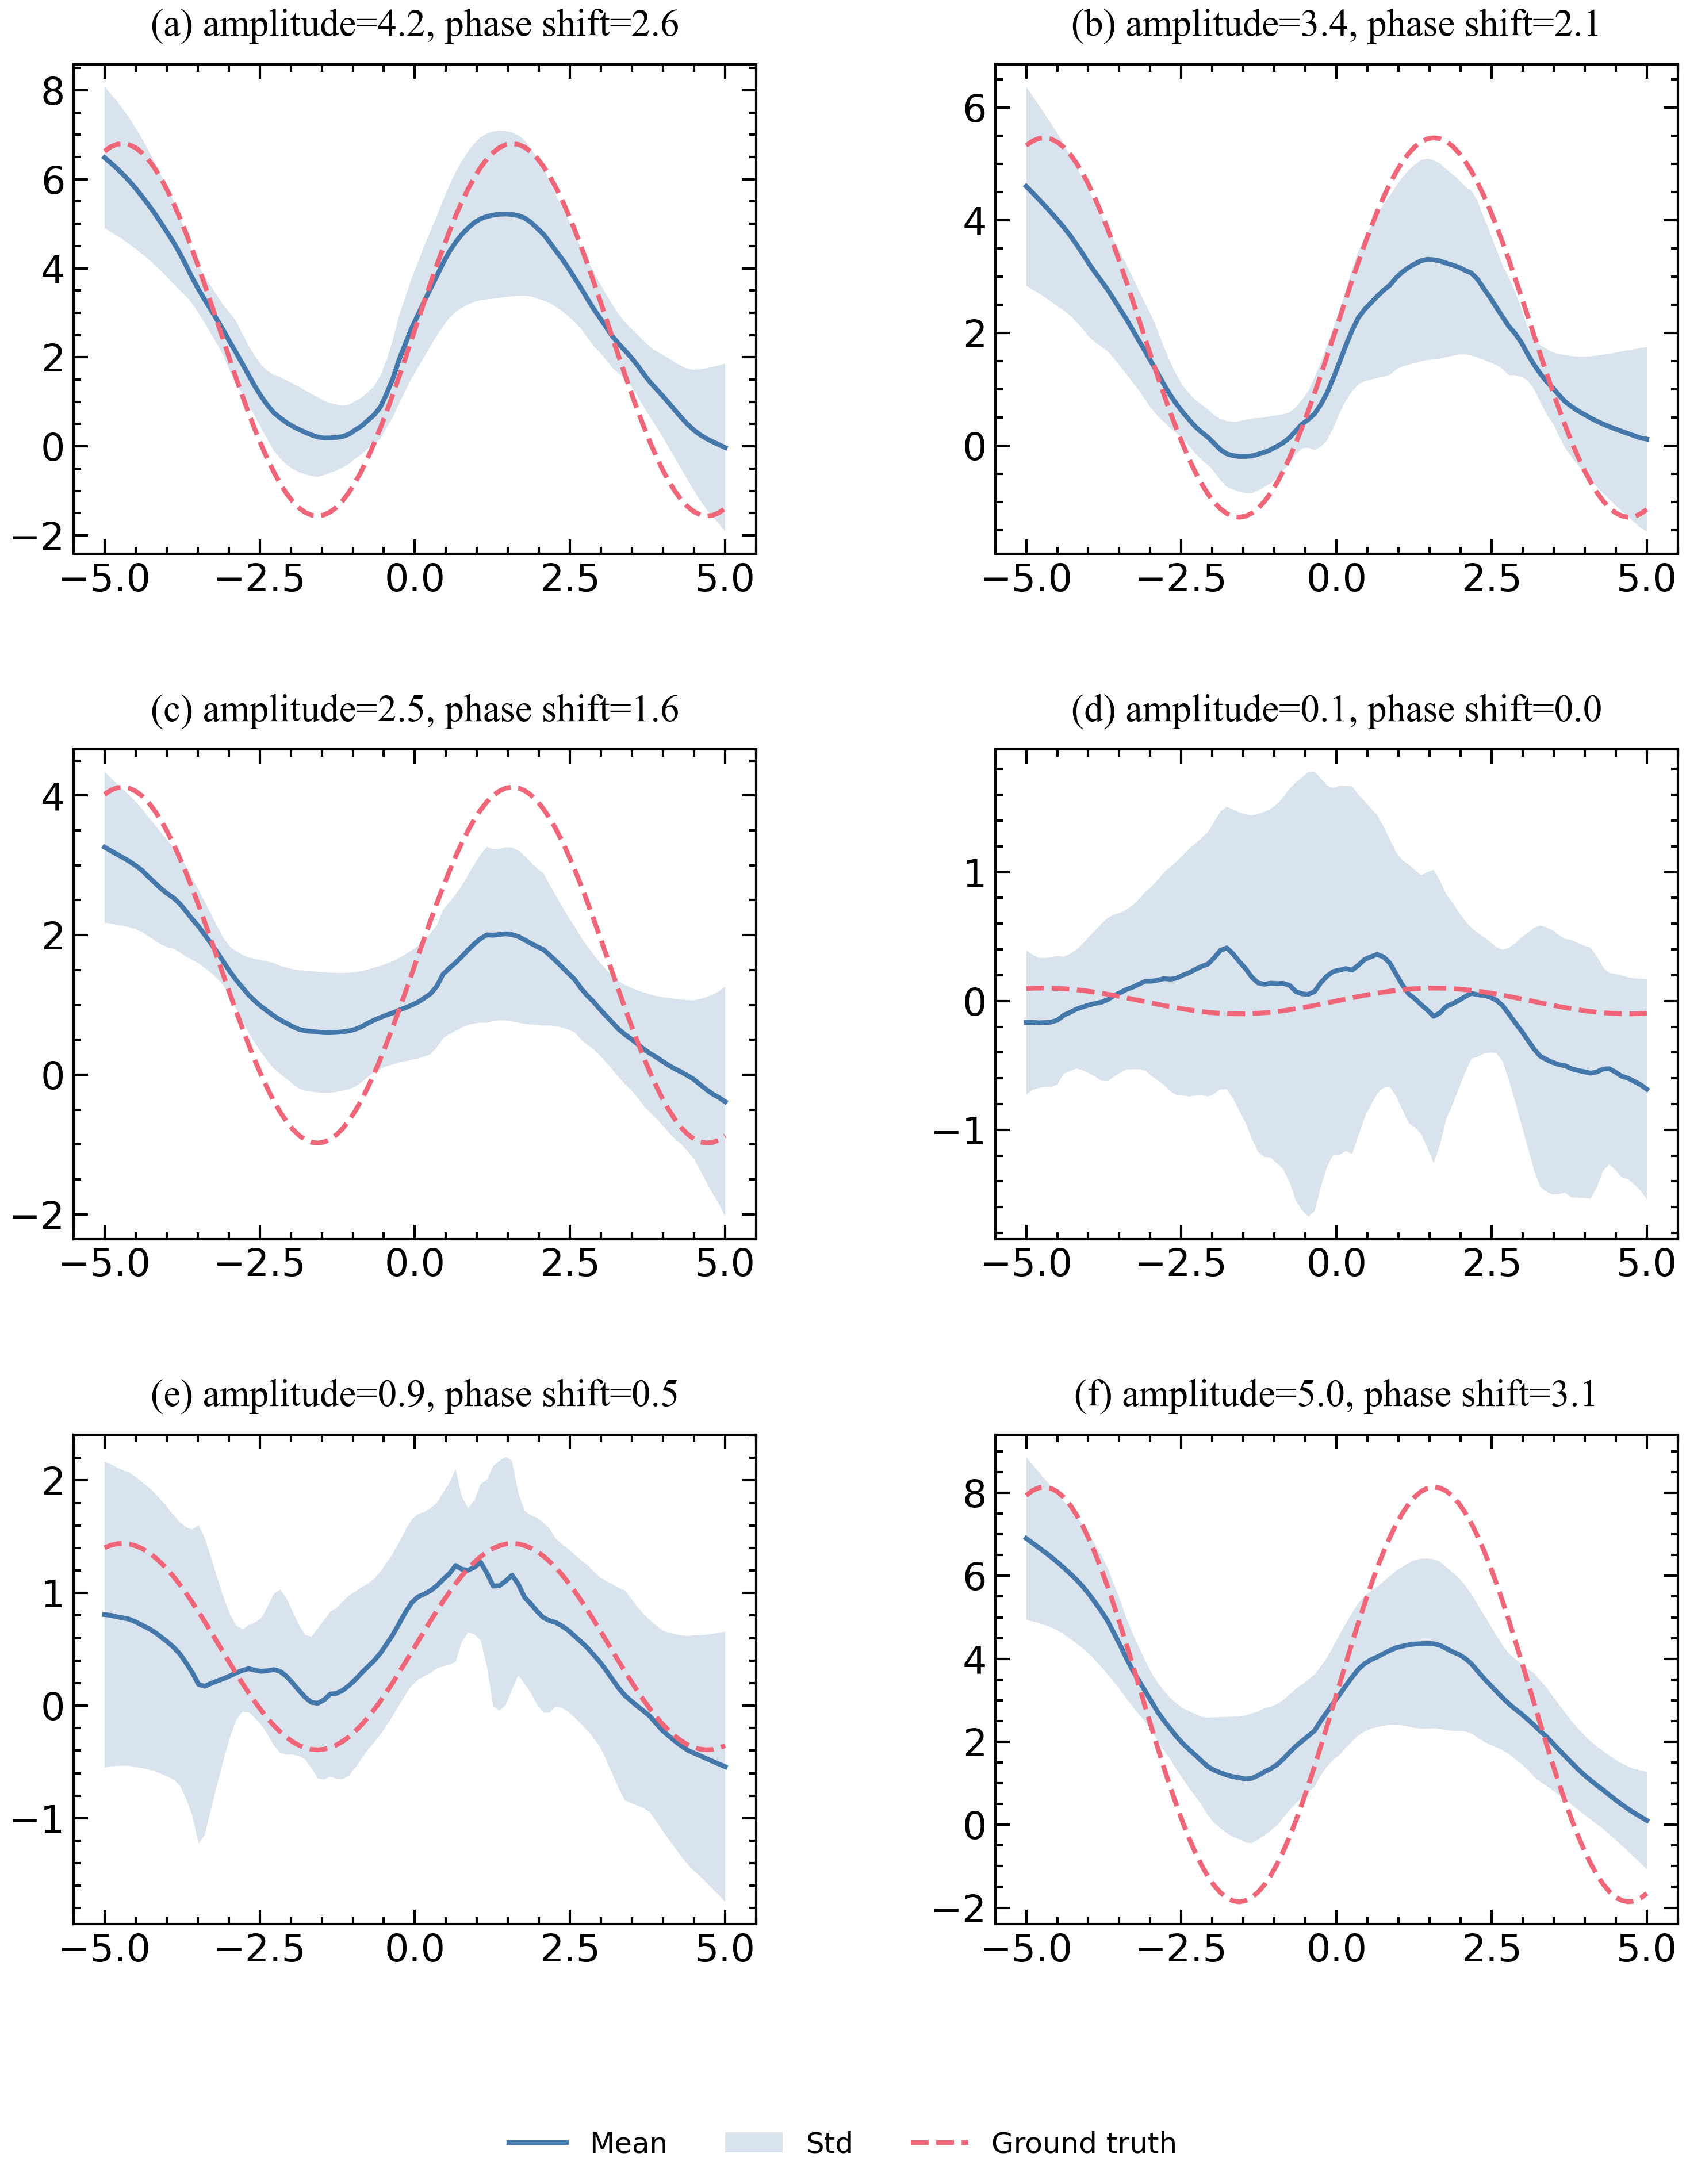

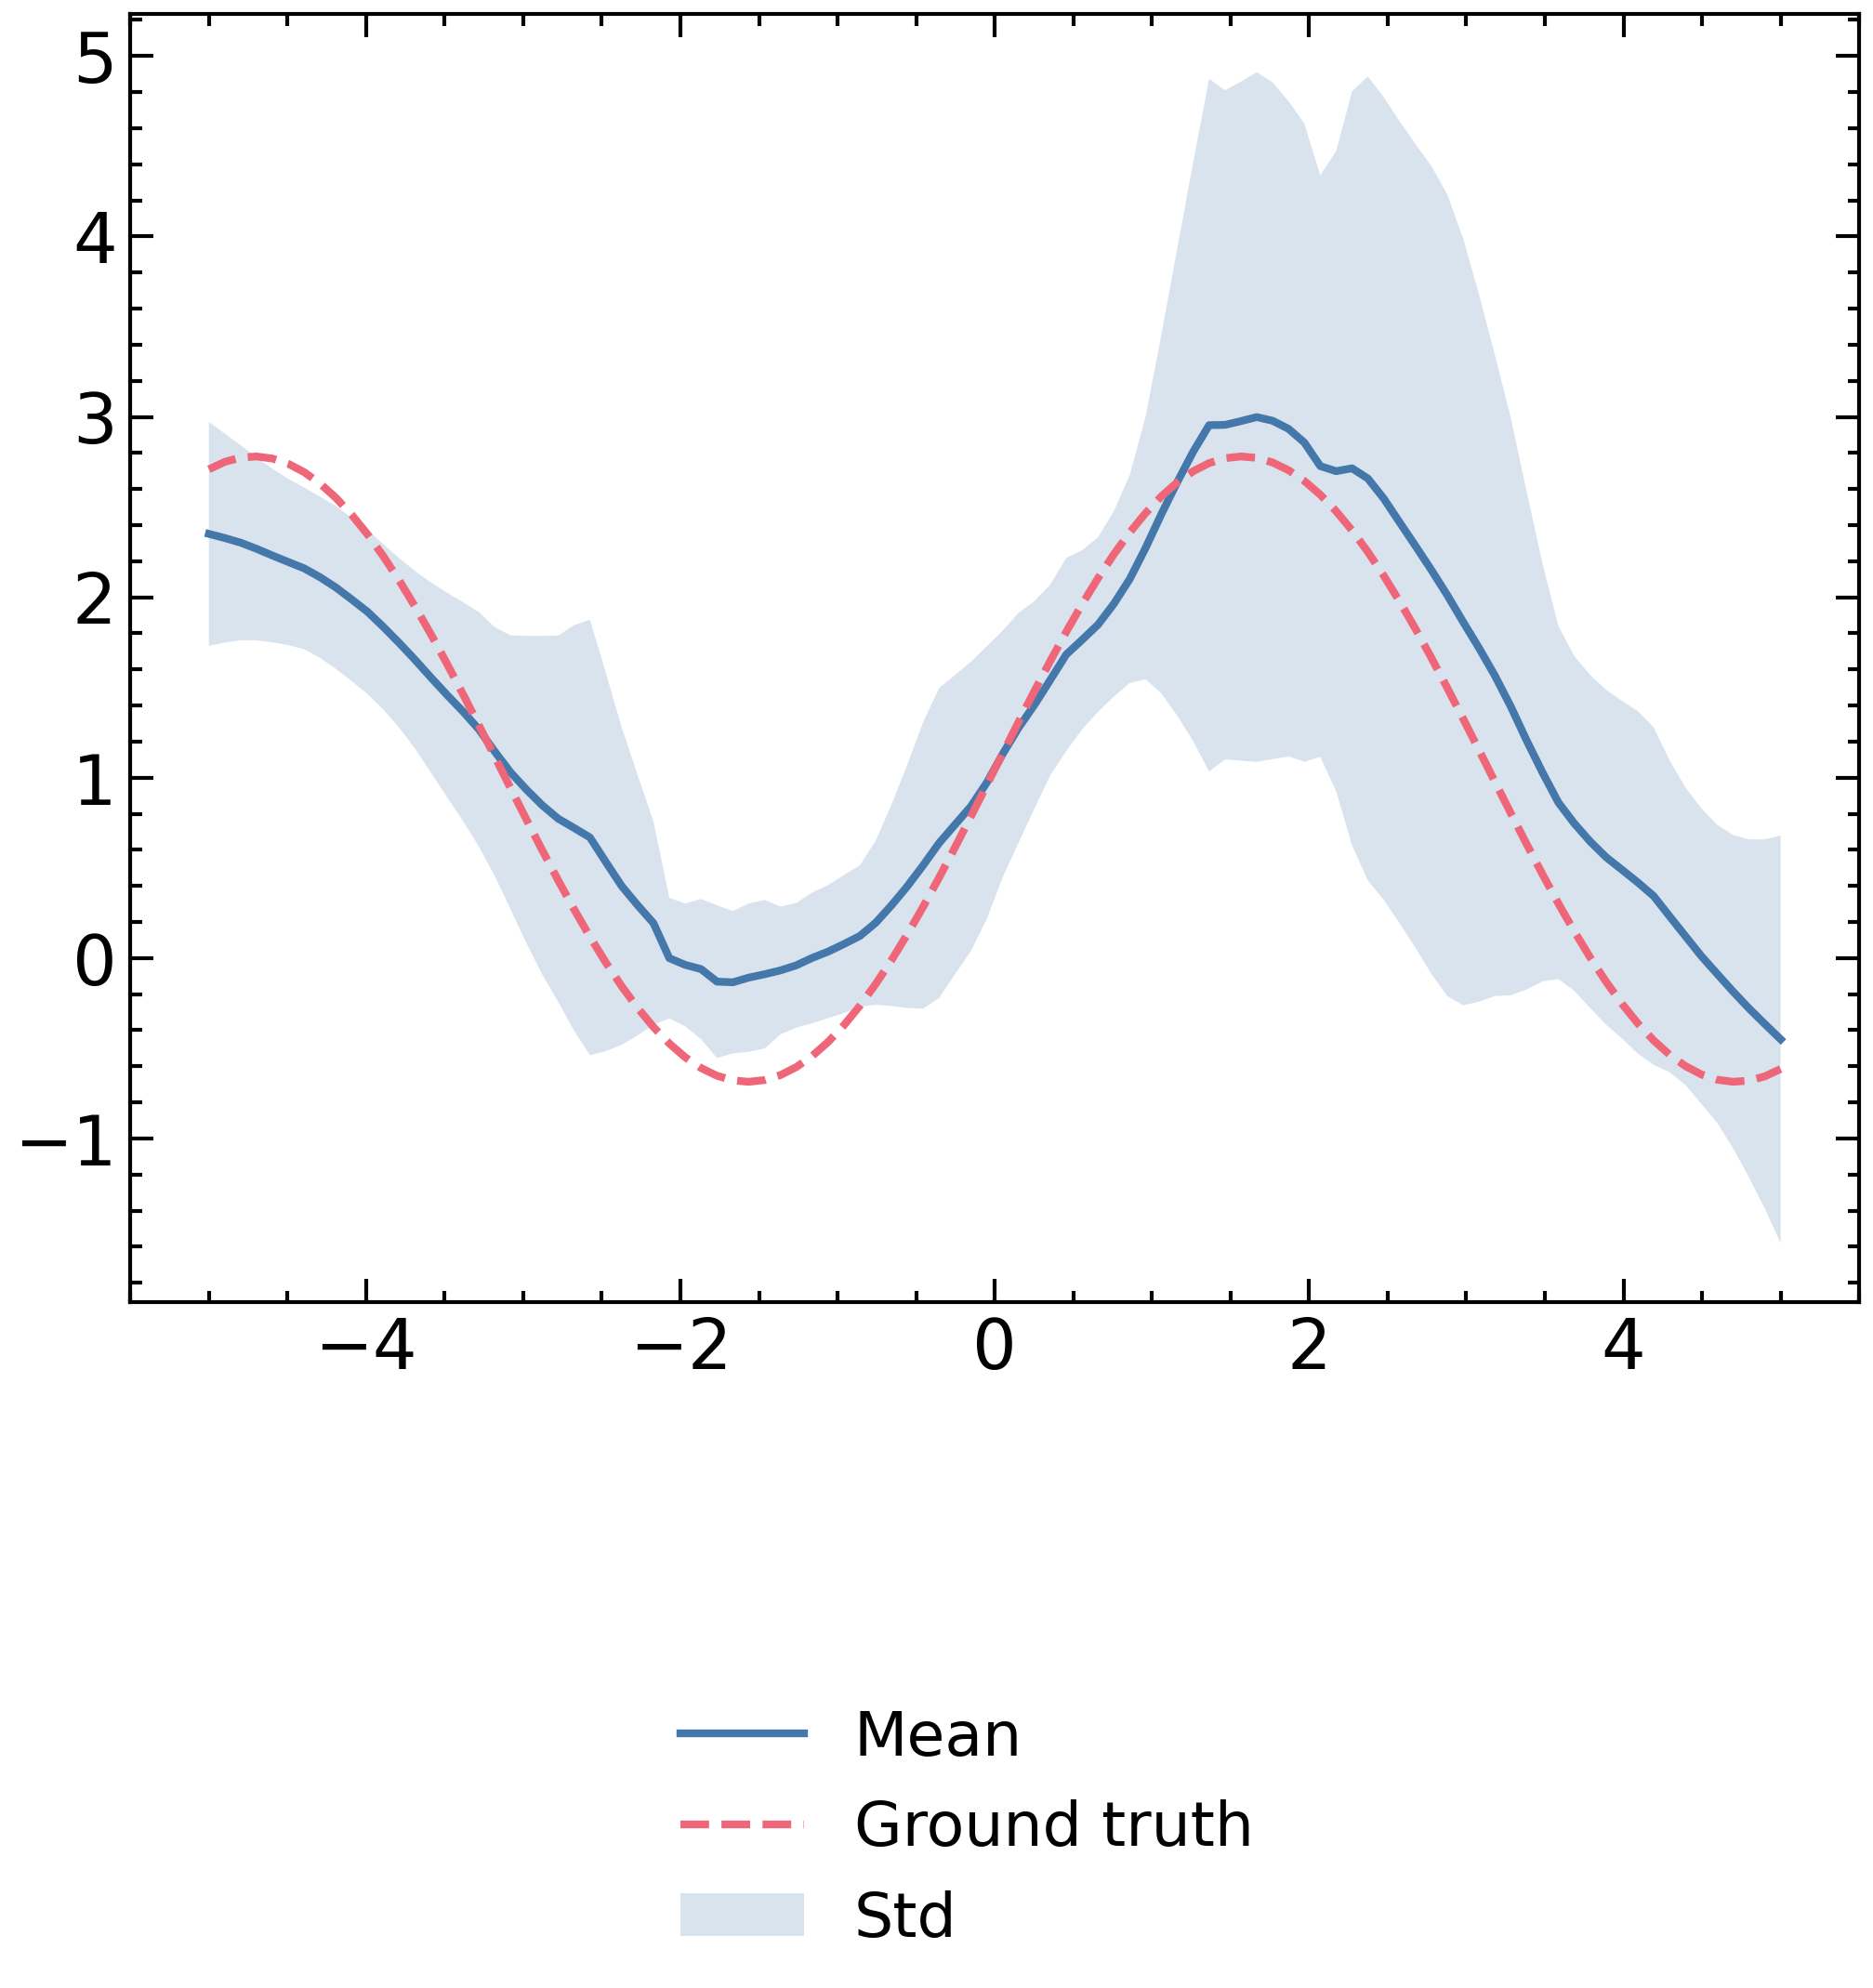

[INFO] Image saved to slurm/RecurrentPPO_1220_16-59/sine_curves_eval.png


In [207]:
plot_sine_curves(remls=remls, tasks=training_tasks, path=data_path, grid=True, image=True)
plot_sine_curves(remls=remls, tasks=[eval_task], path=data_path, grid=False, image=True)

In [ ]:
plot_data_with_variance(data=cumureward, path=data_path, eval_task_num=eval_task.info['i'], xlabel="Returns", title="Return by epoch", image=True)
plot_data_with_variance(data=cumuloss, path=data_path, eval_task_num=eval_task.info['i'], xlabel="Cumulative loss", title="Cumulative loss by epoch", image=True)
plot_data_with_variance(data=errors, path=data_path, eval_task_num=eval_task.info['i'], xlabel="Errors", title="Errors by epoch", image=True)

In [ ]:
plot_few_shot_learning(reml=reml, path=data_path, eval_task=eval_task, k=5, image=True)
plot_few_shot_learning(reml=reml, path=data_path, eval_task=eval_task, k=10, image=True)